Стандартные бибилиотеки

In [59]:
!pip install pymorphy2 -q
!pip install sentence_transformers -q
!pip install wordcloud -q
!pip install gigachat -q

!pip install Pillow -q
!pip install reportlab -q

In [ ]:
from sklearn.cluster import KMeans, kmeans_plusplus, DBSCAN, AgglomerativeClustering, SpectralClustering
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from tqdm import tqdm
from nltk.corpus import stopwords
from sentence_transformers import SentenceTransformer
from collections import Counter
from gigachat import GigaChat

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import pymorphy2
import seaborn as sns
import nltk

In [ ]:
np.random.seed(42)

Убрем здесь стопслова и односимвольные ответы

In [ ]:
# Загрузка необходимых данных
nltk.download('stopwords')

# Получение списка русских стоп-слов
stopwords_ru = stopwords.words("russian")

reg_stop = '|'.join(map(lambda x: f'(^{x}$)',
                        stopwords_ru)) + '|(^из-за$)|(^из-под$)|(^.$)'  #|(^.*[иы]й$)' # в стоп-словах не было этих союзов

In [ ]:
reg = r'[^А-Яа-я /-]'
bad_reg = r'(.*ху.*)|(.*пиз.*)|(.*еба.*)|(.*еби.*)' + rf'|{reg_stop}'  # обработаем плохие слова и стоп слова
# На месте words будет чтение файла со словами
df = pd.read_excel('dataset.xlsx').fillna('').astype(str)
words = np.array(df.iloc[:, 0])

# Обрати внимание, что тут я прогоняю только 1 список слов - по факту это только один столбец. Если столбцов несколько, то надо цикл
words = [re.sub(reg, '', word.lower()).strip() for word in words]

Лемматизуем

In [ ]:
morph = pymorphy2.MorphAnalyzer()
dict_lemmas_to_words = {}
lemmas = []
# words = ['корову', 'люблю собаку', '', 'из-за денег']
for word in words:
    data = word.split()
    if len(data) == 1:
        lemmas.append(morph.parse(word)[0].normal_form)
        if word:
            dict_lemmas_to_words[lemmas[-1]] = word
    else:
        lemmas.append(' '.join([morph.parse(w)[0].normal_form for w in data if not (re.search(bad_reg, w))]))
        if word:
            dict_lemmas_to_words[lemmas[-1]] = word

lemmas = [word for word in lemmas if not (re.search(bad_reg, word)) and word]

In [ ]:
# Загрузка модели SBERT
# model = SentenceTransformer('all-MiniLM-L6-v2') # Она подходит для задач, таких как кластеризация и семантический поиск.
# model = SentenceTransformer('paraphrase-MiniLM-L6-v2') # Эта модель специально настроена для задач, связанных с парафразированием и семантическим сходством.
model = SentenceTransformer('stsb-roberta-base')  # сработала пока лучше всех - нацелена на синтематику
# model = SentenceTransformer('distiluse-base-multilingual-cased') #показал себя так себе, поддерживает множество языков и подходит для задач, связанных с многозначностью и различными языковыми структурами.
# model = SentenceTransformer('bert-base-nli-mean-tokens') # в целом тоже круто, но хуже роберты

sentences = lemmas  # Добавить леммы

# Получение эмбеддингов
word_vectors = model.encode(sentences)

# Кластеризуем с помощью kmeans_plusplus и найдем инерцию, по ней определим количество кластеров

In [ ]:
ran = range(1, min(len(lemmas) + 1, 50))
inertia_df = pd.DataFrame(data=[], index=ran, columns=['inertia'])
effective_clusters = -1
for n_clusters in tqdm(ran):
    try:
        effective_clusters += 1
        centers, indices = kmeans_plusplus(np.array(word_vectors), n_clusters=n_clusters, random_state=10)
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        cluster_labels = kmeans.fit_predict(word_vectors)
        inertia_df.loc[n_clusters] = kmeans.inertia_
    except:
        break
inertia_df = inertia_df.iloc[:effective_clusters]

In [ ]:
inertia_df.plot()

представим инерцию и ее производную в нормальном виде

In [ ]:
inertia_arr = np.array(inertia_df).flatten()
inertia_derivative = inertia_arr[:-1] - inertia_arr[1:]

Тут не пугаться - это просто класс для град спуска

In [ ]:
class GradSearch(object):
    def __init__(self, a=1.0, b=0.0, x0=1.0, l=1e-2):
        self.a = a
        self.b = b
        self.x0 = x0
        self.l = l
        self.loss = []

    def f(self, x, y, a, b, x0):
        return 0.5 * pow(y - a * np.exp(-x / x0) - b, 2).sum()

    def dfda(self, x, y, a, b, x0):
        return ((a * np.exp(-x / x0) + b - y) * np.exp(-x / x0)).sum()

    def dfdb(self, x, y, a, b, x0):
        return (a * np.exp(-x / x0) + b - y).sum()

    def dfdx0(self, x, y, a, b, x0):
        return ((a * np.exp(-x / x0) + b - y) * a * np.exp(-x / x0) * x / pow(x0, 2)).sum()

    def fit(self, x, y, epochs=1_000):
        self.loss.append(self.f(x, y, self.a, self.b, self.x0))
        for epoch in tqdm(range(epochs)):
            self.a -= self.l * self.dfda(x, y, self.a, self.b, self.x0)
            self.b -= self.l * self.dfdb(x, y, self.a, self.b, self.x0)
            self.x0 -= self.l * self.dfdx0(x, y, self.a, self.b, self.x0)
            self.loss.append(self.f(x, y, self.a, self.b, self.x0))

    def get_a_b_x0(self):
        return self.a, self.b, self.x0

Идея такая. В физике есть радиус Дебая - такое расстояние, при котором взаимодействие уменьшается в $e$ раз. Дебаевский радиус - эффективный размер распространения взаимодействия. Давайте сделаем то же самое с инерцией - дебаевским расстоянием будет количество кластеров, на котором апроксимированная функцией $f(x)$ инерция будет уменьшаться в $e$ раз.

Изначально я хотел заменить инерцию на более гладкую $f(x) = a \cdot e^{-\frac{x}{x_0}} + b$, где $a, b, x_0$ - настраиваемые параметры - как раз град спуск для них. Но потом подумал, что можно сразу использовать дебаевский формализм к инерции без преобразования.

Использование гладкой $f(x) = a \cdot e^{\frac{x}{x_0}} + b$ позволяет убрать различные выбросы и зигзаги (например, у производной инерции - там ваще свистопляска происходит).

In [ ]:
x, y = np.array(range(inertia_arr.shape[0])), np.array(inertia_arr).flatten()
y_norm = y.max()
y /= y_norm

grad = GradSearch(a=1.0, b=0.0, x0=1.0, l=1e-2)
grad.fit(x, y, epochs=100_000)

In [ ]:
plt.plot(grad.loss)

In [ ]:
a, b, x0 = grad.get_a_b_x0()
a, b, x0

In [ ]:
ind = np.ceil(x0).astype(int)
ind

In [ ]:
t = np.linspace(x.min(), x.max(), 1000)
y_pred = a * np.exp(-t / x0) + b

plt.figure(figsize=(18, 8))
plt.title('Зависимость нормированной инерции от количества кластеров')
plt.plot(x + 1, y.flatten(), label='Inertia')
plt.plot(t + 1, y_pred, label=r'$a \cdot e^{-x/x_0} + b$')
#plt.axhline(y=(a + b) / np.e, color='r', linestyle='--', linewidth=2, label='$y = \dfrac{1}{e} \simeq 0.368$')
plt.xticks(range(0, inertia_arr[1:].shape[0] + 4, 4))
plt.xlabel('Amount_of_clusters')
plt.ylabel('Inertia')
plt.legend()
plt.grid()

Кластеризуем в соответствии с найденными кластерами

In [ ]:
n_clusters = ind
centers, indices = kmeans_plusplus(np.array(word_vectors), n_clusters=n_clusters, random_state=10)
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(word_vectors)

df = pd.DataFrame(lemmas, columns=['word'])
df['cluster'] = cluster_labels

Выберем рандомное слово в каждом кластере и посчитаем сколько слов всего в кластере

In [ ]:
counter = {}
for i in range(n_clusters):
    w = np.random.choice(df[df['cluster'] == i]['word'])
    amount = df[df['cluster'] == i].shape[0]
    counter[dict_lemmas_to_words[w]] = amount

In [ ]:
df[df['cluster'] == 0].word.apply(lambda x: dict_lemmas_to_words[x])

Сохраним этот словарь в формате JSON

In [ ]:
# with open('counter_data.json', 'w') as json_file:
#     json.dump(counter, json_file, indent=4)

Визуализируем в **seaborn**

In [ ]:
plt.figure(figsize=(18, 8))
ax = sns.histplot(cluster_labels, bins=n_clusters, shrink=0.5, kde=True)

bin_edges = ax.patches[0].get_bbox().bounds

centers = [patch.get_x() + patch.get_width() / 2 for patch in ax.patches]

plt.title('Диаграмма кластеров')
plt.xticks(centers, np.arange(n_clusters))
plt.yticks(range(0, max(counter.values()) + 1, 2))
plt.xlabel('Cluster_number')
plt.grid()

plt.show()

In [ ]:
label_colors = [
    'k',
    'b',
    'g',
    'orange',
    'm',
    'r',
    "#F5DEB3",  # Wheat
    #"#FFEBCD" ,   # Blanched Almond
    '#00FFFF',  # Cyan / Aqua
    '#0000FF',  # Blue
    '#008000',  # Green
    '#FFFF00',  # Yellow
    '#FFA500',  # Orange
    '#800080',  # Purple
    '#FFC0CB',  # Pink
    '#A52A2A',  # Brown
    '#808080',  # Gray
    '#FFFFFF',  # White
    '#000000',  # Black
]

In [ ]:
# pca = PCA(n_components=2)
# df_bin = pca.fit_transform(word_vectors)

df_bin = TSNE(n_components=2, learning_rate='auto',
              init='random', perplexity=100).fit_transform(word_vectors)

df_bin = pd.DataFrame(df_bin)
df_bin['cluster'] = np.array(cluster_labels)
df_bin

In [ ]:
dct_of_labels = {}

for cluster in set(cluster_labels):
    dct_of_labels[cluster] = df_bin[df_bin['cluster'] == cluster].index

In [ ]:
plt.figure(figsize=(12, 8))

for label, ind in dct_of_labels.items():
    sns.scatterplot(x=df_bin.iloc[ind, 0], y=df_bin.iloc[ind, 1], c=label_colors[label], label=f'{label}', s=50)

plt.grid()
plt.show()

In [ ]:
counter

In [ ]:
autho_key = 'your_privat_key'


def get_answer(prompt: str) -> str:
    """A wrapper for using the GigaChat API.

      Parameters:
        prompt (str) : prompt to GigaChat API

    Returns:
        response (str) : responce from GigaChat
    """
    with GigaChat(credentials=autho_key, verify_ssl_certs=False) as giga:
        response = giga.chat(prompt)
    return response.choices[0].message.content


# Example
answers = []
for i in tqdm(range(n_clusters)):
    ans = get_answer(f'''
    Выдели из данного предложения основной смысл одной фразой (длина до 5 слов): "{list(counter.keys())[i]}",
    во фразе обязательно должно быть хотя бы 1 слово.
    ''')
    answers.append(ans)

for i in tqdm(range(len(answers))):
    answers[i] += get_answer(f'''
    Оцени эмоциональный окрас этой фразы: {answers[i]} одним числом по шкале от -10 до 10, где -10 обозначает абсолютно негативное
    предложение, 10 - абсолютно позитивное. Шаблон ответа: *фраза*. Оценка <>.
    ''')

# answers

In [ ]:
result = []
marks = []
for ans in answers:
    marks.append(int(re.findall(r'-?\d{2}|-?\d{1}', ans)[-1]))
    result.append(ans.split('.')[0])

In [ ]:
answers_with_emotions = {name: (val, mark) for name, val, mark in zip(result, counter.values(), marks)}

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


def get_bar_statistic(ans_info, names, index):
    EMOTION_COLORS = ['#e8e8e8', '#5ddd5d', '#FF6B6B']

    ans_info = dict(sorted(ans_info.items(), key=lambda x: x[1][0], reverse=True))
    labels = []
    values = []
    emotions = []
    val_cnt = 0
    all_cnt = sum([val[0] for val in ans_info.values()])

    for name, (cnt, emotion) in ans_info.items():
        if cnt / all_cnt <= 0.02:
            val_cnt += cnt
        else:
            labels.append(re.sub(r'[^A-Za-zА-Яа-я \-0-9]', '', name))
            values.append(cnt)
            emotions.append(emotion)

    if val_cnt != 0:
        labels.append('Иные категории')
        values.append(val_cnt)
        emotions.append(0)
    cluster_colors = [EMOTION_COLORS[np.sign(val)] for val in emotions]

    fig, ax = plt.subplots(figsize=(12, 10))
    barplot = sns.barplot(x=values, y=labels, width=0.5, palette=cluster_colors, hue=labels)

    for container in barplot.containers:
        barplot.bar_label(container, fmt=' {:.0f}')

    plt.title(names, fontsize=14)

    plt.gca().axes.get_xaxis().set_visible(False)
    sns.despine(bottom=True)

    # Сохраняем с высоким качеством
    plt.savefig(f'bar_{index}.png', dpi=300,
                bbox_inches='tight')  # Используйте bbox_inches='tight' для уменьшения обрезки
    plt.show()


def get_pie_statistic(ans_info, title, index):
    ans_info = {key: val for key, (val, _) in ans_info.items()}
    ans_info = dict(sorted(ans_info.items(), key=lambda x: x[1], reverse=True))

    labels = []
    values = []
    all_cnt = sum(ans_info.values())
    val_cnt = 0
    for name, cnt in ans_info.items():
        if cnt / all_cnt <= 0.02:
            val_cnt += cnt
        else:
            labels.append(re.sub(r'[^A-Za-zА-Яа-я \-0-9]', '', name))
            values.append(cnt)

    if val_cnt != 0:
        labels.append('Иные категории')
        values.append(val_cnt)

    colors = sns.color_palette("pastel", len(labels))
    fig, ax = plt.subplots(figsize=(12, 10))

    plt.pie(values, colors=colors, startangle=90,
            wedgeprops=dict(width=0.4, edgecolor='white'),
            autopct='%1.0f%%', pctdistance=1.1)

    plt.legend(labels, loc="best")
    plt.axis('equal')

    plt.title(title, fontsize=14)

    # Сохраняем с высоким качеством
    plt.savefig(f'pie_{index}.png', dpi=300, bbox_inches='tight')
    plt.show()


# Используйте get_graphics как ранее, чтобы создать графики


def get_graphics():
    for question_num in range(df.shape[1]):
        column_name = list(df.columns)[question_num]
        get_bar_statistic(answers_with_emotions, column_name, question_num)
        get_pie_statistic(answers_with_emotions, column_name, question_num)


In [ ]:
get_graphics()

In [ ]:
from reportlab.pdfgen import canvas
from reportlab.lib.pagesizes import A4
from reportlab.pdfbase.ttfonts import TTFont
from reportlab.pdfbase import pdfmetrics
from PIL import Image
import os

Image.MAX_IMAGE_PIXELS = None


def create_pdf_with_multiple_images(output_pdf, image_paths, title, captions, image_per_page=2):
    # Создаем новый PDF файл
    c = canvas.Canvas(output_pdf, pagesize=A4)

    # Задаем размеры страницы
    page_width, page_height = A4

    # Указываем путь к шрифту (убедитесь, что шрифт поддерживает кириллицу)
    font_path = "DejaVuSans.ttf"
    pdfmetrics.registerFont(TTFont('DejaVu', font_path))

    # Используем шрифт для текста
    c.setFont("DejaVu", 20)

    # Обрабатываем все изображения
    for i in range(0, len(image_paths), image_per_page):
        # Создаем новую страницу с заголовком
        c.drawCentredString(page_width / 2, page_height - 50, title)

        for j in range(image_per_page):
            index = i + j
            if index >= len(image_paths):
                break

            # Открываем изображение
            img = Image.open(image_paths[index])

            # Пропорционально уменьшаем изображения, чтобы они помещались на странице
            img_width = page_width - 100  # Учитываем отступы
            img_height = img.height * (img_width / img.width)  # Пропорциональная высота

            if img_height > (
                    page_height - 100) / image_per_page:  # Проверяем, если высота превышает оставшееся пространство
                img_height = (page_height - 100) / image_per_page  # Высота для каждого изображения
                img_width = img.width * (img_height / img.height)  # Пропорциональная ширина

            # Центрируем изображение по горизонтали
            img_x = (page_width - img_width) / 2

            # Располагаем изображение на странице
            img_y = page_height - (j + 1) * img_height - 60  # Выравниваем по вертикали

            # Сохраняем временные изображения с измененным размером
            # img.thumbnail((img_width, img_height), Image.Resampling.LANCZOS)
            img.save(f"temp_image_{index}.png")

            # Рисуем изображение на странице
            c.drawImage(f"temp_image_{index}.png", img_x, img_y, width=img_width, height=img_height)

            # Добавляем подпись к изображению
            # c.setFont("DejaVu", 12)
            # c.drawCentredString(page_width / 2, img_y - 20, captions[index])

        # Переход на новую страницу, если не все изображения размещены
        c.showPage()

    # Закрываем PDF файл
    c.save()

    # Удаляем временные изображения
    for index in range(len(image_paths)):
        os.remove(f"temp_image_{index}.png")


# Данные для создания PDF
image_paths = ["bar_0.png", "pie_0.png", "bar_1.png", "pie_1.png"]
captions = ["Подпись 1", "Подпись 2", "Подпись 3", "Подпись 4"]
title = "Мои изображения"
output_pdf = "output_with_multiple_images.pdf"

# Создаем PDF с изображениями, по 2 на страницу
create_pdf_with_multiple_images(output_pdf, image_paths, title, captions)


# DBscan (сработало так себе)

In [ ]:
db = DBSCAN(eps=1, min_samples=1).fit(word_vectors)
clusters_dbscan = db.labels_

sns.histplot(clusters_dbscan, shrink=0.5)

In [ ]:
Counter(clusters_dbscan)

После длительного варьирования парматеров DBscan не показал хороших результатов

# Гаусс

In [ ]:
silhouette_scores = []

# Проверка различных значений количества кластеров
K = range(2, 30)  # Начинаем с 2, так как агломеративная кластеризация требует минимум 2 кластера
for k in tqdm(K):
    clustering = AgglomerativeClustering(n_clusters=k)
    labels = clustering.fit_predict(word_vectors)
    silhouette_avg = silhouette_score(word_vectors, labels)  # Вычисляем среднее значение силуэта
    silhouette_scores.append(silhouette_avg)
silhouette_scores = np.array(silhouette_scores)
# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(K, silhouette_scores, 'bo-')
plt.xlabel('Количество кластеров')
plt.ylabel('Среднее значение силуэта')
plt.title('Метод локтя для определения количества кластеров (Agglomerative Clustering)')
plt.xticks(K)
plt.grid()
plt.show()

In [ ]:
first_val = silhouette_scores[0]
ind = silhouette_scores.argmin() + 2
window = 10

for i in range(3, len(silhouette_scores)):
    if all(silhouette_scores[i: i + window] > first_val):
        ind = i + 1
        break
ind

In [ ]:
n_clusters = ind

clustering = AgglomerativeClustering(n_clusters=n_clusters)
cluster_labels = clustering.fit_predict(word_vectors)

df = pd.DataFrame(lemmas, columns=['word'])
df['cluster'] = cluster_labels

In [ ]:
counter = {}
for i in range(n_clusters):
    w = np.random.choice(df[df['cluster'] == i]['word'])
    amount = df[df['cluster'] == i].shape[0]
    counter[dict_lemmas_to_words[w]] = amount

In [ ]:
plt.figure(figsize=(18, 8))
ax = sns.histplot(cluster_labels, bins=n_clusters, shrink=0.5, kde=True)

bin_edges = ax.patches[0].get_bbox().bounds

centers = [patch.get_x() + patch.get_width() / 2 for patch in ax.patches]

plt.title('Диаграмма кластеров')
plt.xticks(centers, np.arange(n_clusters))
plt.yticks(range(0, max(counter.values()) + 1, 2))
plt.xlabel('Cluster_number')
plt.grid()

plt.show()

Тут получается ерунда если делать град спуск, попытки сгладить ломаную фильтрами и сплайнами не принесли результатов.

In [ ]:
# pca = PCA(n_components=2)
# df_bin = pca.fit_transform(word_vectors)

df_bin = TSNE(n_components=2, learning_rate='auto',
              init='random', perplexity=100).fit_transform(word_vectors)

df_bin = pd.DataFrame(df_bin)
df_bin['cluster'] = np.array(cluster_labels)
df_bin

In [ ]:
dct_of_labels = {}

for cluster in set(cluster_labels):
    dct_of_labels[cluster] = df_bin[df_bin['cluster'] == cluster].index

In [ ]:
plt.figure(figsize=(12, 8))

for label, ind in dct_of_labels.items():
    sns.scatterplot(x=df_bin.iloc[ind, 0], y=df_bin.iloc[ind, 1], c=label_colors[label], label=f'{label}', s=50)

plt.grid()
plt.show()

# CLARANS (сработало так себе, потому что очень долго)

In [ ]:
!pip install pyclustering -q

In [ ]:
from pyclustering.cluster.clarans import clarans
import numpy as np

# Параметры для CLARANS
number_of_clusters = 2
max_neighbors = 3
num_local = 5

# Создание экземпляра CLARANS
clarans_instance = clarans(word_vectors, number_of_clusters, max_neighbors, num_local)

# Запуск алгоритма
clarans_instance.process()

# Получение результатов кластеризации
clusters = clarans_instance.get_clusters()

# Вывод результатов
for i, cluster in enumerate(clusters):
    print(f"Cluster {i + 1}: {data[cluster]}")

# Спектральная (сработало так себе)

  0%|          | 0/28 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:455: UserWarning: Exited at iteration 551 with accuracies 
[2.69950915e-15 2.15095004e-05 6.35250677e-06]
not reaching the requested tolerance 7.852911949157715e-06.
Use iteration 521 instead with accuracy 
7.105999180591642e-06.

  _, diffusion_map = lobpcg(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:455: UserWarning: Exited postprocessing with accuracies 
[2.23887543e-15 8.29560243e-06 1.30223953e-05]
not reaching the requested tolerance 7.852911949157715e-06.
  _, diffusion_map = lobpcg(
  7%|▋         | 2/28 [00:37<08:01, 18.51s/it]/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:455: UserWarning: Exited at iteration 2000 with accuracies 
[3.97873179e-15 5.38093986e-06 1.01697380e-05 2.52972655e-06
 1.57852627e-05]
not reaching the requested tolerance 7.852911949157715e-06.
Use iteration 1489 instea

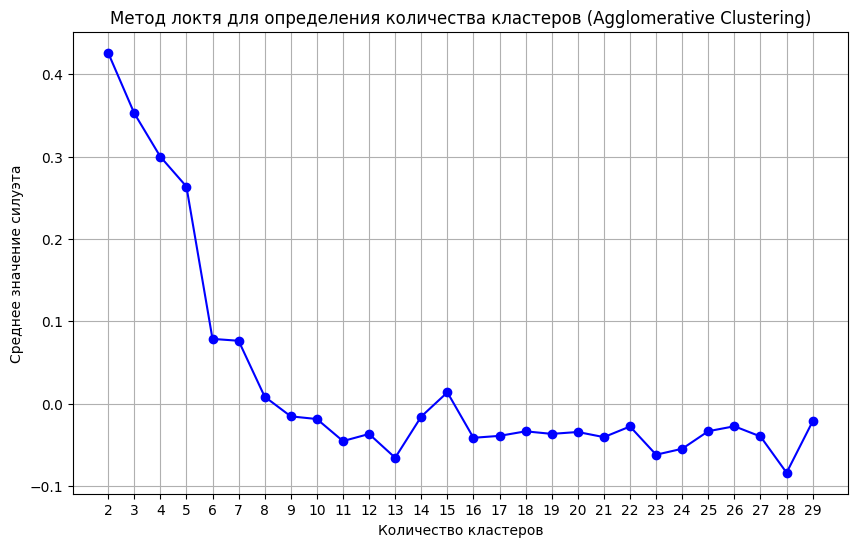

In [120]:
silhouette_scores = []
r = range(2, 30)
for n_clusters in tqdm(r):
    spectral_clustering = SpectralClustering(n_clusters=n_clusters, affinity='rbf', random_state=42)
    labels = spectral_clustering.fit_predict(word_vectors)

    # Вычисление среднего коэффициента силуэта
    silhouette_avg = silhouette_score(word_vectors, labels)
    silhouette_scores.append(silhouette_avg)

silhouette_scores = np.array(silhouette_scores)

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(r, silhouette_scores, 'bo-')
plt.xlabel('Количество кластеров')
plt.ylabel('Среднее значение силуэта')
plt.title('Метод локтя для определения количества кластеров (Agglomerative Clustering)')
plt.xticks(K)
plt.grid()
plt.show()

In [121]:
n_clusters = 15
spectral_clustering = SpectralClustering(n_clusters=n_clusters, affinity='rbf', random_state=42)
cluster_labels = spectral_clustering.fit_predict(word_vectors)

df['cluster'] = cluster_labels

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:455: UserWarning: Exited at iteration 1783 with accuracies 
[3.56022336e-11 2.59040812e-07 3.01332781e-07 7.52929356e-07
 7.98385699e-07 1.36390080e-06 1.58032210e-06 9.94081045e-07
 2.76130390e-06 3.46715350e-06 2.80204982e-06 3.73068643e-06
 4.56132981e-06 7.66395718e-06 2.06130003e-06 1.15975883e-05]
not reaching the requested tolerance 7.852911949157715e-06.
Use iteration 1783 instead with accuracy 
2.7934623246252998e-06.

  _, diffusion_map = lobpcg(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:455: UserWarning: Exited postprocessing with accuracies 
[5.66530216e-11 2.84405730e-07 1.86836915e-07 7.78239780e-07
 7.99245526e-07 1.36461068e-06 1.58051620e-06 9.94013867e-07
 2.77166287e-06 3.45910788e-06 2.80197863e-06 3.73233260e-06
 4.58003552e-06 7.65222970e-06 2.05854124e-06 1.15978502e-05]
not reaching the requested tolerance 7.852911949157715e-06.
  _, diffusion_ma

In [122]:
counter = {}
for i in range(n_clusters):
    w = np.random.choice(df[df['cluster'] == i]['word'])
    amount = df[df['cluster'] == i].shape[0]
    counter[dict_lemmas_to_words[w]] = amount

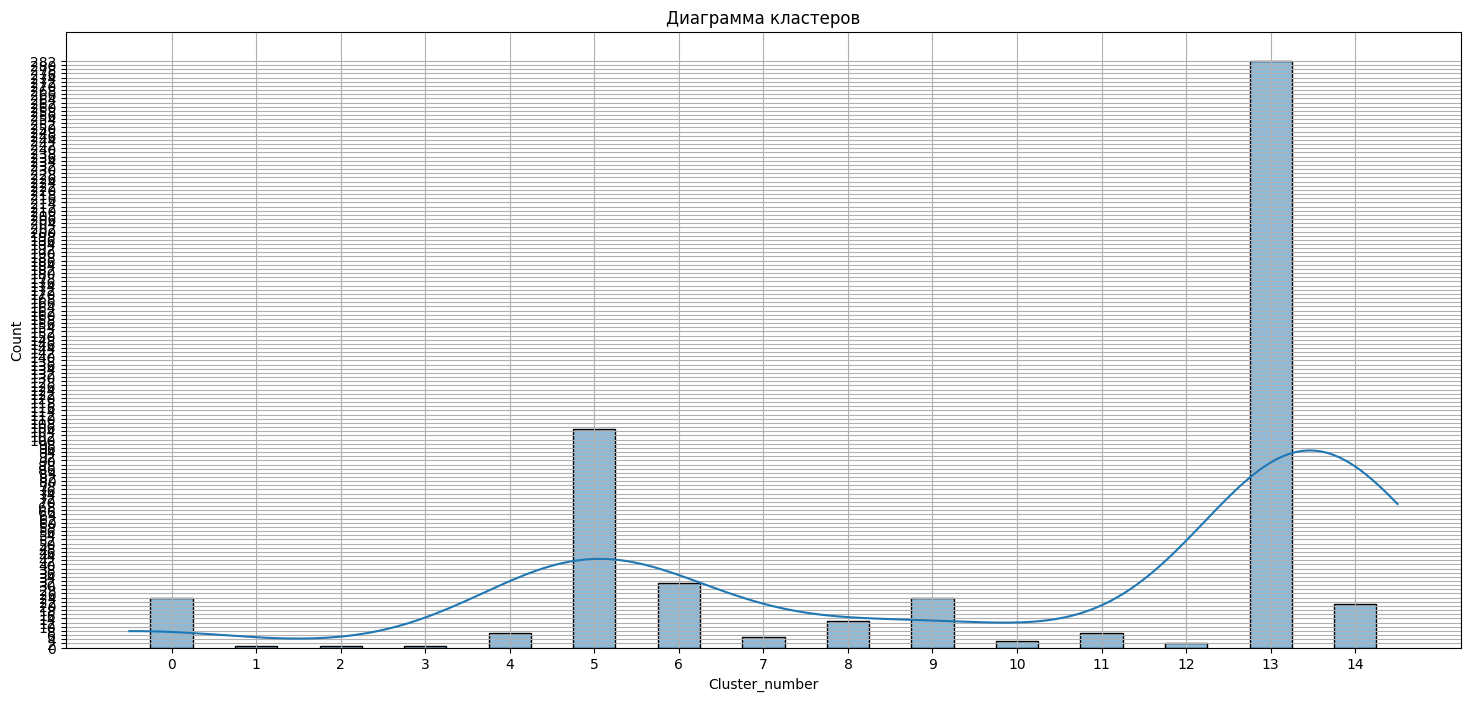

In [123]:
plt.figure(figsize=(18, 8))
ax = sns.histplot(cluster_labels, bins=n_clusters, shrink=0.5, kde=True)

bin_edges = ax.patches[0].get_bbox().bounds

centers = [patch.get_x() + patch.get_width() / 2 for patch in ax.patches]

plt.title('Диаграмма кластеров')
plt.xticks(centers, np.arange(n_clusters))
plt.yticks(range(0, max(counter.values()) + 1, 2))
plt.xlabel('Cluster_number')
plt.grid()

plt.show()

In [124]:
# pca = PCA(n_components=2)
# df_bin = pca.fit_transform(word_vectors)

df_bin = TSNE(n_components=2, learning_rate='auto',
              init='random', perplexity=100).fit_transform(word_vectors)

df_bin = pd.DataFrame(df_bin)
df_bin['cluster'] = np.array(cluster_labels)
df_bin

,0,1,cluster
0,8.504879,2.935502,9
1,6.466458,0.125655,13
2,-8.074574,2.811730,1
3,-1.082374,1.545497,13
4,-2.923604,-0.056118,13
...,...,...,...
522,-0.095124,0.728940,13
523,3.581022,6.298246,13
524,-0.250375,2.536385,13
525,1.090514,-4.946575,9


In [125]:
dct_of_labels = {}

for cluster in set(cluster_labels):
    dct_of_labels[cluster] = df_bin[df_bin['cluster'] == cluster].index

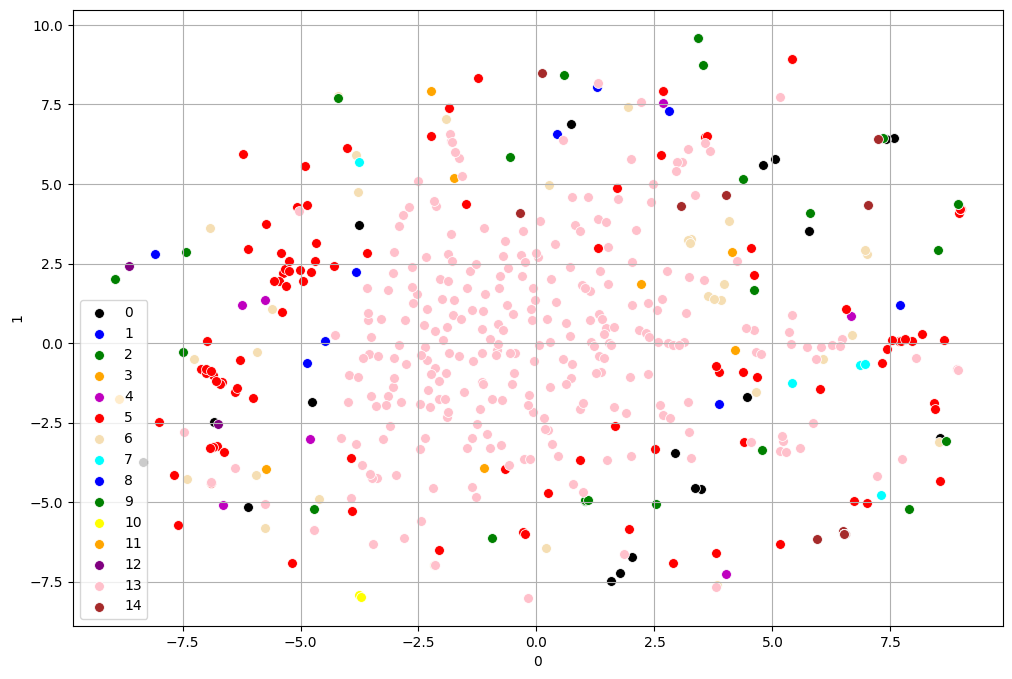

In [126]:
plt.figure(figsize=(12, 8))

for label, ind in dct_of_labels.items():
    sns.scatterplot(x=df_bin.iloc[ind, 0], y=df_bin.iloc[ind, 1], c=label_colors[label], label=f'{label}', s=50)

plt.grid()
plt.show()